# Training data

In [2]:
import pickle
import numpy as np
import random
from operator import add

In [3]:
f = open ('./char_embedding.pkl', 'rb')
dict_char = pickle.load(f)
f.close()

f = open ('./dataset/item_index_withEN.pkl', 'rb')
item_index = pickle.load(f)
f.close()

f = open ('./dataset/name_index_withEN.pkl', 'rb')
user_index = pickle.load(f)
f.close()

In [4]:
rating_mat = np.load('dataset/user_item_withEN_mat.npy')

In [5]:
print("dict_char", len(dict_char))
print("user_index", len(user_index))
print("item_index", len(item_index))
print("rating_mat", rating_mat.shape)

dict_char 21592
user_index 15251
item_index 32
rating_mat (15251, 32)


In [6]:
#dict_char['沈']
#user_list.remove('')
k, v = random.choice(list(dict_char.items()))
print(type(v))
#print(user_list)

<class 'numpy.ndarray'>


In [8]:
user_list = list(user_index.keys())
print(len(user_list))
user_mat = []
user_con_mat = []
user_emb = []
con_emb = []
count = 0

for user in user_list:
    temp = []
    for char in user:
        try:
            temp.append(dict_char[char])
        except:
            count += 1
            k, v = random.choice(list(dict_char.items()))
            temp.append(v)
    #print(len(temp))
    if len(temp) == 2:
        # k, v = random.choice(list(dict_char.items()))
        user_emb = np.mean([temp[0], temp[1]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[1]))
    elif len(temp) == 3:
        user_emb = np.mean([temp[0], temp[1], temp[2]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    elif len(temp) == 4:
        user_emb = np.mean([temp[0], temp[1], temp[2], temp[-1]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    else:
        print("index", user_list.index(user))
        #rating_mat = np.delete(rating_mat, [user_list.index(user)], axis=0)
        user_list.remove(user)
        del user_index[user]
        print(len(temp))
    user_con_mat.append(con_emb)
    user_mat.append(user_emb)

user_mat = np.array(user_mat)
user_con_mat = np.array(user_con_mat)
print("missing char", count)
print("user_mat", user_mat.shape)
print("user_con_mat", user_con_mat.shape)
print("remain", len(user_list))
print("remain", rating_mat.shape)

15250
missing char 190
user_mat (15250, 256)
user_con_mat (15250, 768)
remain 15250
remain (15250, 32)


In [9]:
#item_shape = (256, 32)
#item_mat = np.random.rand(32, 256)
print(user_mat)

[[-0.25516173  0.02200902 -0.6367982  ...  0.27963406  0.06052778
  -0.2570803 ]
 [-0.00804286 -0.43483147 -0.4136071  ...  0.5910477   0.11055978
  -0.76872826]
 [-0.18077803 -0.28984937 -0.42697546 ...  0.38626578  0.0096873
  -0.5621365 ]
 ...
 [ 0.31248116 -0.27425033  0.06705994 ...  0.5632503   0.6493718
  -0.25115702]
 [-0.59236026  0.25725064  0.44351003 ...  0.8128228  -0.12497162
  -0.08346231]
 [-0.06863866  0.05283417  0.21988375 ...  0.6965713   0.10992792
  -0.58061045]]


In [10]:
num_user = 15250
num_item = 32

# Model

In [185]:
from keras import Model
import keras.backend as K
from keras.layers import Embedding,Reshape,Input,Dot, Dense, dot, Lambda
from keras.models import load_model
K.clear_session()

In [201]:
import matplotlib.pyplot as plt

In [85]:
# def create_model(num_user, num_item, k):
#     input_user = Input(shape=(256,),dtype="float32")
#     #model_uer = Embedding(num_user+1,k,input_length = 1)(input_uer)
#     model_user = Dense(k, activation='relu')(input_user)
#     model_user = Reshape((k,))(model_user)
    
#     input_item = Input(shape=(32,),dtype="float32")
#     model_item  = Embedding(num_item+1,k,input_length = 32)(input_item)
#     model_item = Dense(256, activation='relu')(model_item)
#     model_item = Reshape((256,))(model_item)
    
#     out = Dot(1)([model_user,model_item])
#     model = Model(inputs=[input_user,model_item], outputs=out)
#     model.compile(loss='mse', optimizer='Adam')
#     model.summary()
#     return model

In [224]:
def Recmand_model(num_user,num_item,k):
    input_uer = Input(shape=(768, ),dtype="float32")
    model_uer = Dense(256, activation='relu')(input_uer)
    model_uer = Dense(128, activation='relu')(model_uer)
    model_uer = Dense(k, activation='relu')(model_uer)
    
    
    input_item = Input(shape=(1,), dtype="float32")
    model_item  = Embedding(num_item, k, input_length = 1)(input_item)
    model_item = Reshape((k,))(model_item)
    
    out = Lambda(lambda x: K.sum(x[0]*x[1], axis=-1, keepdims=True))([model_uer, model_item])
    model = Model(inputs=[input_uer, input_item], outputs=out)
    model.compile(loss='mse', optimizer='Adam')
    model.summary()
    return model

In [225]:
model = Recmand_model(num_user, num_item, 64)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          196864      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [175]:
# batch_size = 10
test_user = np.random.random((10, 256))
test_item = np.random.randint(0,32, (10))

In [176]:
print(test_user)

[[0.98150853 0.70062474 0.13726937 ... 0.1607718  0.9482678  0.28295064]
 [0.18701608 0.67779834 0.75381696 ... 0.41377164 0.2374937  0.91917589]
 [0.91128038 0.60146085 0.19532374 ... 0.60367989 0.0329808  0.08523302]
 ...
 [0.29103944 0.46783427 0.38640484 ... 0.73774472 0.89547298 0.70397321]
 [0.58210377 0.44913554 0.13051729 ... 0.24020321 0.72692221 0.16707797]
 [0.77469958 0.50775915 0.56931871 ... 0.45033486 0.25050769 0.73255657]]


In [177]:
print(test_item)

[27 19  0 12 19 29  2 30  2 28]


In [178]:
# test predict
#model.predict([np.random.random((10, 256)), np.random.randint(0,32, (10))])

In [179]:
#print(user_con_mat)
print(user_mat)

[[-0.25516173  0.02200902 -0.6367982  ...  0.27963406  0.06052778
  -0.2570803 ]
 [-0.00804286 -0.43483147 -0.4136071  ...  0.5910477   0.11055978
  -0.76872826]
 [-0.18077803 -0.28984937 -0.42697546 ...  0.38626578  0.0096873
  -0.5621365 ]
 ...
 [ 0.31248116 -0.27425033  0.06705994 ...  0.5632503   0.6493718
  -0.25115702]
 [-0.59236026  0.25725064  0.44351003 ...  0.8128228  -0.12497162
  -0.08346231]
 [-0.06863866  0.05283417  0.21988375 ...  0.6965713   0.10992792
  -0.58061045]]


In [180]:
user_index = 0
item_index = 0
train_x = []
train_user = []
train_item = []

for u in rating_mat:
    for i in u:
        if i == 1:
            # train_x.append([user_mat[user_index], [item_index]])
            u_list = user_con_mat[user_index].tolist()
            train_user.append(u_list)
            #train_user.append(user_mat[user_index].tolist())
            #print(user_mat[user_index].tolist())
            train_item.append(item_index)
        item_index += 1
    user_index += 1
    item_index = 0
train_x = [np.array(train_user), np.array(train_item)]

In [181]:
#train_x = np.array(train_x)
print(train_x)
#print(train_x)
train_y = [1] * 39911
train = [1] * 10
#print(train_y)

[array([[-0.74557173, -0.02800325, -0.72160846, ...,  0.50239176,
         0.42607114, -0.61805236],
       [-0.74557173, -0.02800325, -0.72160846, ...,  0.50239176,
         0.42607114, -0.61805236],
       [-0.74557173, -0.02800325, -0.72160846, ...,  0.50239176,
         0.42607114, -0.61805236],
       ...,
       [-0.02675579, -0.89014792,  0.57638884, ...,  0.35549855,
         0.82068586,  0.22624786],
       [-0.48385873,  0.44448829,  0.65895814, ...,  1.33896124,
        -0.20171902, -0.70200801],
       [ 0.01715979,  0.4324117 ,  0.38358891, ...,  0.98461074,
         0.39813921, -0.48753178]]), array([6, 7, 8, ..., 0, 0, 0])]


In [182]:
history = model.fit(train_x, train_y, batch_size = 64, epochs =300, verbose=1, validation_split=0.2, shuffle=True)

Train on 31928 samples, validate on 7983 samples
Epoch 1/300
31928/31928 [==============================] - 3s 101us/step - loss: 0.0094 - val_loss: 0.2577
Epoch 2/300
31928/31928 [==============================] - 3s 80us/step - loss: 2.4459e-04 - val_loss: 0.2480
Epoch 3/300
31928/31928 [==============================] - 3s 80us/step - loss: 3.2565e-04 - val_loss: 0.2422
Epoch 4/300
31928/31928 [==============================] - 3s 80us/step - loss: 2.2590e-04 - val_loss: 0.2383
Epoch 5/300
31928/31928 [==============================] - 3s 80us/step - loss: 2.6807e-04 - val_loss: 0.2345
Epoch 6/300
31928/31928 [==============================] - 2s 73us/step - loss: 4.2682e-04 - val_loss: 0.2321
Epoch 7/300
31928/31928 [==============================] - 2s 71us/step - loss: 1.4091e-04 - val_loss: 0.2300
Epoch 8/300
31928/31928 [==============================] - 2s 71us/step - loss: 9.8425e-05 - val_loss: 0.2284
Epoch 9/300
31928/31928 [==============================] - 2s 70us/step - 

31928/31928 [==============================] - 2s 70us/step - loss: 1.8736e-05 - val_loss: 0.2136
Epoch 75/300
31928/31928 [==============================] - 2s 70us/step - loss: 1.5568e-05 - val_loss: 0.2132
Epoch 76/300
31928/31928 [==============================] - 2s 70us/step - loss: 1.0181e-05 - val_loss: 0.2132
Epoch 77/300
31928/31928 [==============================] - 2s 71us/step - loss: 2.2372e-05 - val_loss: 0.2133
Epoch 78/300
31928/31928 [==============================] - 2s 72us/step - loss: 1.8501e-05 - val_loss: 0.2133
Epoch 79/300
31928/31928 [==============================] - 2s 71us/step - loss: 6.8488e-06 - val_loss: 0.2133
Epoch 80/300
31928/31928 [==============================] - 2s 74us/step - loss: 2.4849e-05 - val_loss: 0.2134
Epoch 81/300
31928/31928 [==============================] - 2s 72us/step - loss: 7.7910e-06 - val_loss: 0.2135
Epoch 82/300
31928/31928 [==============================] - 2s 71us/step - loss: 1.9655e-05 - val_loss: 0.2134
Epoch 83/300
3

31928/31928 [==============================] - 2s 71us/step - loss: 9.1636e-06 - val_loss: 0.2113
Epoch 148/300
31928/31928 [==============================] - 2s 71us/step - loss: 3.0446e-06 - val_loss: 0.2113
Epoch 149/300
31928/31928 [==============================] - 2s 71us/step - loss: 1.3363e-05 - val_loss: 0.2113
Epoch 150/300
31928/31928 [==============================] - 2s 71us/step - loss: 1.1368e-06 - val_loss: 0.2113
Epoch 151/300
31928/31928 [==============================] - 2s 71us/step - loss: 6.2411e-06 - val_loss: 0.2113
Epoch 152/300
31928/31928 [==============================] - 2s 72us/step - loss: 9.7680e-06 - val_loss: 0.2113
Epoch 153/300
31928/31928 [==============================] - 2s 71us/step - loss: 3.5998e-06 - val_loss: 0.2114
Epoch 154/300
31928/31928 [==============================] - 2s 71us/step - loss: 9.6191e-06 - val_loss: 0.2114
Epoch 155/300
31928/31928 [==============================] - 2s 71us/step - loss: 9.2554e-07 - val_loss: 0.2114
Epoch 

31928/31928 [==============================] - 3s 98us/step - loss: 4.6844e-06 - val_loss: 0.2121
Epoch 221/300
31928/31928 [==============================] - 3s 97us/step - loss: 4.7071e-06 - val_loss: 0.2121
Epoch 222/300
31928/31928 [==============================] - 3s 93us/step - loss: 4.6096e-06 - val_loss: 0.2125
Epoch 223/300
31928/31928 [==============================] - 2s 76us/step - loss: 1.4349e-06 - val_loss: 0.2125
Epoch 224/300
31928/31928 [==============================] - 3s 80us/step - loss: 6.2290e-06 - val_loss: 0.2124
Epoch 225/300
31928/31928 [==============================] - 3s 81us/step - loss: 1.9674e-06 - val_loss: 0.2124
Epoch 226/300
31928/31928 [==============================] - 3s 84us/step - loss: 7.4435e-06 - val_loss: 0.2127
Epoch 227/300
31928/31928 [==============================] - 2s 72us/step - loss: 4.7052e-06 - val_loss: 0.2127
Epoch 228/300
31928/31928 [==============================] - 2s 74us/step - loss: 1.1995e-06 - val_loss: 0.2127
Epoch 

31928/31928 [==============================] - 2s 69us/step - loss: 2.1708e-06 - val_loss: 0.2141
Epoch 294/300
31928/31928 [==============================] - 2s 69us/step - loss: 1.1247e-06 - val_loss: 0.2141
Epoch 295/300
31928/31928 [==============================] - 2s 69us/step - loss: 1.8035e-06 - val_loss: 0.2141
Epoch 296/300
31928/31928 [==============================] - 2s 70us/step - loss: 5.0068e-06 - val_loss: 0.2141
Epoch 297/300
31928/31928 [==============================] - 2s 69us/step - loss: 1.2991e-06 - val_loss: 0.2141
Epoch 298/300
31928/31928 [==============================] - 2s 71us/step - loss: 1.1445e-06 - val_loss: 0.2142
Epoch 299/300
31928/31928 [==============================] - 2s 69us/step - loss: 4.2761e-06 - val_loss: 0.2142
Epoch 300/300
31928/31928 [==============================] - 2s 71us/step - loss: 1.4631e-07 - val_loss: 0.2142


In [183]:
model.save('model_con_300.h5')

In [265]:
model_300 = load_model('./my_model_300.h5')
model_500 = load_model('./my_model_500.h5')
model_con_300 = load_model('./my_model_con_300.h5')

In [266]:
#embeddings = model.layers[2].get_weights()[0]
#embeddings = model.layers[4].get_weights()[0]

In [267]:
# embeddings.shape
# embed = embeddings.T
# print(embed.shape)

## Graph

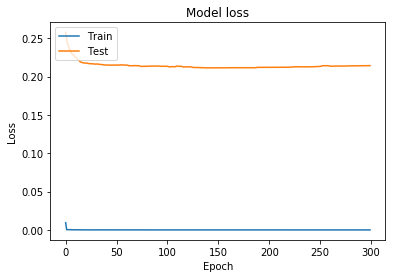

In [268]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predict 

In [269]:
sc_name_dict = {'CGU':"長庚大學", 'CMU':"中國醫藥大學", 'CYCU':"中原大學", 'FCU':"逢甲大學", 'KMU':"高雄醫學大學", 
                'NCCU':"政治大學", 'NCHU':"中興大學", 'NCKU':"成功大學", 'NCTU':"交通大學", 'NCUE':"彰化師範大學", 
                'NDHU':"東華大學", 'NKNU':"高雄師範大學", 'NPTU':"屏東大學", 'NSYSU':"中山大學", 'NTCU':"臺中教育大學", 
                'NTHU':"清華大學", 'NTNU':"臺灣師範大學", 'NTU':"臺灣大學", 'NTUE':"臺北教育大學", 'NUTN':"臺南大學",
                'SCU':"東吳大學", 'THU':"東海大學", 'TKU':"淡江大學", 'TNUA':"臺北藝術大學", 'UTAIPEI':"臺北市立大學",
                'YM':"陽明大學"}

In [286]:
names = ["馬崇堯", "盧秀燕", "黃崇明", "龍傲天", "黃智賢", "韓國瑜", "林芊吟"]
#name = "周東誼"
h_name = ["黃宜軒", "黃譯", "黃品閎", "黃信瑩", "黃鈺妤"]
w_name = ["王文萱", "王郁婷", "王凱", "王昱均", "王平婷"]
l_name = ["林政勳", "林聖穎", "林文軒", "林世威", "林嘉蓁"]
c_name = ["陳芝臻", "陳彥融", "陳昱澤", "陳志軒", "陳彥諺"]

In [287]:
def getCharEmbed(name):
    temp = []
    for char in name:
        try:
            temp.append(dict_char[char])
        except:
            k, v = random.choice(list(dict_char.items()))
            temp.append(v)
            
    if len(temp) == 2:
        # k, v = random.choice(list(dict_char.items()))
        user_emb = np.mean([temp[0], temp[1]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[1]))
    elif len(temp) == 3:
        user_emb = np.mean([temp[0], temp[1], temp[2]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    elif len(temp) == 4:
        user_emb = np.mean([temp[0], temp[1], temp[2], temp[-1]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    else:
        for i in range(3):
            k, v = random.choice(list(dict_char.items()))
            temp.append(v)
        user_emb = v
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    
    #return user_emb
    return con_emb

In [288]:
us = []
for name in names:
    u = getCharEmbed(name)
    us.append(u)
sc = np.array(range(32))

In [289]:
print(us[0].shape)

(768,)


In [290]:
#model.predict([np.random.random((10, 256)), np.random.randint(0,32, (10))])
#np.random.random((10, 256))

In [291]:
f = open ('./dataset/item_index_withEN.pkl', 'rb')
item_index_dict = pickle.load(f)
f.close()

item_index_dict 

{'董事': 0,
 '董事長': 1,
 '獨立董事': 2,
 '副董事長': 3,
 '常務董事': 4,
 '執行業務股東': 5,
 'CGU': 6,
 'CMU': 7,
 'CYCU': 8,
 'FCU': 9,
 'KMU': 10,
 'NCCU': 11,
 'NCHU': 12,
 'NCKU': 13,
 'NCTU': 14,
 'NCUE': 15,
 'NDHU': 16,
 'NKNU': 17,
 'NPTU': 18,
 'NSYSU': 19,
 'NTCU': 20,
 'NTHU': 21,
 'NTNU': 22,
 'NTU': 23,
 'NTUE': 24,
 'NUTN': 25,
 'SCU': 26,
 'THU': 27,
 'TKU': 28,
 'TNUA': 29,
 'UTAIPEI': 30,
 'YM': 31}

In [292]:
def getSchool(item_index_dict, score_list):
    broad_list = []
    for i in range(len(score_list)):
        if score_list[i] == 1:
            for k, v in item_index_dict.items():
                if v == i:
                    broad_list.append(k)
    return broad_list

In [293]:
for i in range(len(us)):
    print(names[i])
    u = us[i]
    score_list = []
    for i in range(32):
        output = model_con_300.predict([[u], [i]])
        if output[0][0] > 0.82:
            score_list.append(1)
        else:
            score_list.append(0)
    print(score_list)
    output_list = getSchool(item_index_dict, score_list)

馬崇堯
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
盧秀燕
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
黃崇明
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]
龍傲天
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
黃智賢
[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
韓國瑜
[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
林芊吟
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [294]:
#print(score_list)

In [295]:
output_list = getSchool(item_index_dict, score_list)

In [296]:
print(output_list)
print(len(output_list))

[]
0


In [307]:
def predictSchool(name):
    count = 0
    max_score = 0
    max_sc_index = 0
    print(name)
    u = getCharEmbed(name)
    score_list = []
    ori_score_dict = {}
    for i in range(32):
        output = model_con_300.predict([[u], [i]])
        #output = model.predict([[u], [i]])
        ori_score_dict[output[0][0]] = i
        if output[0][0] > max_score:
            max_score = output[0][0]
            max_sc_index = i
        if output[0][0] > 0.82:
            score_list.append(1)
            count += 1
        else:
            score_list.append(0)
        
    ori_score_list = list(ori_score_dict.keys())
    ori_score_list.sort(reverse=True)
    
    print("你會上的機率前五高學校或職位有 :", end=" ")
    # print(ori_score_dict)
    # print(list(ori_score_dict.keys()))
    for ori in ori_score_list[:5]:
        print(list(sc_name_dict.values())[ori_score_dict[ori]-6], end=" ")
    #if count > 0:
    print("\n機率最大的是:", list(sc_name_dict.values())[max_sc_index-6])
    
    #print("你有超過八成機率會上的學校或職位有 :", count, "個")
    output_list = getSchool(item_index_dict, score_list)
    #print("你有超過八成機率會上的學校或職位有 :", end=" ")
    #for out in output_list:
        #print(sc_name_dict[out], end=" ")
    #print("\n")
    
    
        #print(max_sc_index)
    #print("\n")
    max_sc_index = 0
    

In [309]:
for name in l_name:
    predictSchool(name)
print("\n")
for name in h_name:
    predictSchool(name)
print("\n")
for name in w_name:
    predictSchool(name)
print("\n")
for name in c_name:
    predictSchool(name)
# for name in names:
#     predictSchool(name)

林政勳
你會上的機率前五高學校或職位有 : 屏東大學 臺南大學 臺北市立大學 政治大學 清華大學 
機率最大的是: 屏東大學
林聖穎
你會上的機率前五高學校或職位有 : 臺灣大學 臺南大學 逢甲大學 清華大學 淡江大學 
機率最大的是: 臺灣大學
林文軒
你會上的機率前五高學校或職位有 : 清華大學 臺灣大學 東華大學 長庚大學 彰化師範大學 
機率最大的是: 清華大學
林世威
你會上的機率前五高學校或職位有 : 臺南大學 屏東大學 東海大學 臺北市立大學 中興大學 
機率最大的是: 臺南大學
林嘉蓁
你會上的機率前五高學校或職位有 : 臺南大學 政治大學 臺中教育大學 逢甲大學 長庚大學 
機率最大的是: 臺南大學


黃宜軒
你會上的機率前五高學校或職位有 : 臺南大學 逢甲大學 政治大學 中山大學 臺北市立大學 
機率最大的是: 臺南大學
黃譯
你會上的機率前五高學校或職位有 : 臺南大學 東華大學 屏東大學 中山大學 彰化師範大學 
機率最大的是: 臺南大學
黃品閎
你會上的機率前五高學校或職位有 : 中山大學 臺中教育大學 逢甲大學 臺灣師範大學 長庚大學 
機率最大的是: 中山大學
黃信瑩
你會上的機率前五高學校或職位有 : 清華大學 臺灣大學 東華大學 臺中教育大學 長庚大學 
機率最大的是: 清華大學
黃鈺妤
你會上的機率前五高學校或職位有 : 臺灣大學 東華大學 臺南大學 政治大學 屏東大學 
機率最大的是: 臺灣大學


王文萱
你會上的機率前五高學校或職位有 : 臺中教育大學 臺灣大學 清華大學 逢甲大學 臺北教育大學 
機率最大的是: 臺中教育大學
王郁婷
你會上的機率前五高學校或職位有 : 清華大學 臺灣大學 東華大學 成功大學 淡江大學 
機率最大的是: 清華大學
王凱
你會上的機率前五高學校或職位有 : 臺南大學 臺灣大學 逢甲大學 中興大學 臺北市立大學 
機率最大的是: 臺南大學
王昱均
你會上的機率前五高學校或職位有 : 臺灣大學 屏東大學 清華大學 東海大學 政治大學 
機率最大的是: 臺灣大學
王平婷
你會上的機率前五高學校或職位有 : 清華大學 臺灣大學 東華大學 長庚大學 臺南大學 
機率最大的是: 清華大學


陳芝臻
你會上的機率前五高學校或職位有 : 政治大學 臺南大學 逢甲大學 臺中教育大學 屏東大學 
機率最大的

In [310]:
predictSchool("韓國瑜")

韓國瑜
你會上的機率前五高學校或職位有 : 臺南大學 東海大學 屏東大學 政治大學 臺灣大學 
機率最大的是: 臺南大學


In [233]:
predictSchool("黃崇明")

黃崇明
你會上的機率前五高學校或職位有 : 臺南大學 東海大學 臺灣大學 臺中教育大學 逢甲大學 
機率最大的是: 臺南大學

你有超過八成機率會上的學校或職位有 : 15 個
你有超過八成機率會上的學校或職位有 : 長庚大學 逢甲大學 政治大學 交通大學 東華大學 屏東大學 中山大學 臺中教育大學 臺灣師範大學 臺灣大學 臺北教育大學 臺南大學 東海大學 臺北藝術大學 臺北市立大學 





In [234]:
predictSchool("王麒詳")

王麒詳
你會上的機率前五高學校或職位有 : 中山大學 臺南大學 臺灣大學 東華大學 逢甲大學 
機率最大的是: 中山大學

你有超過八成機率會上的學校或職位有 : 26 個
你有超過八成機率會上的學校或職位有 : 長庚大學 中國醫藥大學 中原大學 逢甲大學 高雄醫學大學 政治大學 中興大學 成功大學 交通大學 彰化師範大學 東華大學 高雄師範大學 屏東大學 中山大學 臺中教育大學 清華大學 臺灣師範大學 臺灣大學 臺北教育大學 臺南大學 東吳大學 東海大學 淡江大學 臺北藝術大學 臺北市立大學 陽明大學 





In [235]:
predictSchool("趙偉廷")

趙偉廷
你會上的機率前五高學校或職位有 : 臺灣大學 清華大學 淡江大學 東華大學 長庚大學 
機率最大的是: 臺灣大學

你有超過八成機率會上的學校或職位有 : 0 個
你有超過八成機率會上的學校或職位有 : 





In [236]:
predictSchool("黃仁暐")

黃仁暐
你會上的機率前五高學校或職位有 : 清華大學 臺中教育大學 政治大學 長庚大學 臺灣大學 
機率最大的是: 清華大學

你有超過八成機率會上的學校或職位有 : 19 個
你有超過八成機率會上的學校或職位有 : 長庚大學 中國醫藥大學 逢甲大學 政治大學 成功大學 彰化師範大學 東華大學 屏東大學 中山大學 臺中教育大學 清華大學 臺灣大學 臺北教育大學 臺南大學 東海大學 淡江大學 臺北藝術大學 臺北市立大學 陽明大學 





In [237]:
predictSchool("吳昭儀")

吳昭儀
你會上的機率前五高學校或職位有 : 中山大學 臺灣大學 清華大學 東華大學 臺南大學 
機率最大的是: 中山大學

你有超過八成機率會上的學校或職位有 : 5 個
你有超過八成機率會上的學校或職位有 : 東華大學 中山大學 清華大學 臺灣大學 臺南大學 





In [238]:
predictSchool("林芊吟")

林芊吟
你會上的機率前五高學校或職位有 : 長庚大學 清華大學 臺灣大學 東吳大學 東華大學 
機率最大的是: 長庚大學

你有超過八成機率會上的學校或職位有 : 0 個
你有超過八成機率會上的學校或職位有 : 



